# Import Library

In [1]:
import csv 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import glob
import os
import re

# Ground Truth data by yolov8x-pose

In [7]:
#root directory
rootDir = r"C:\Users\kawaw\cpp\JointsTracking_2cams_v1\JointsTracking_2cams_v1"
#left
yoloFile_left = os.path.join(rootDir,"left_gt.csv")
dfGT_left = pd.read_csv(filepath_or_buffer=yoloFile_left)
dataGT_left = dfGT_left.values
#right
yoloFile_right = os.path.join(rootDir,"right_gt.csv")
dfGT_right = pd.read_csv(filepath_or_buffer=yoloFile_right)
dataGT_right = dfGT_right.values


## Plot ground truth data

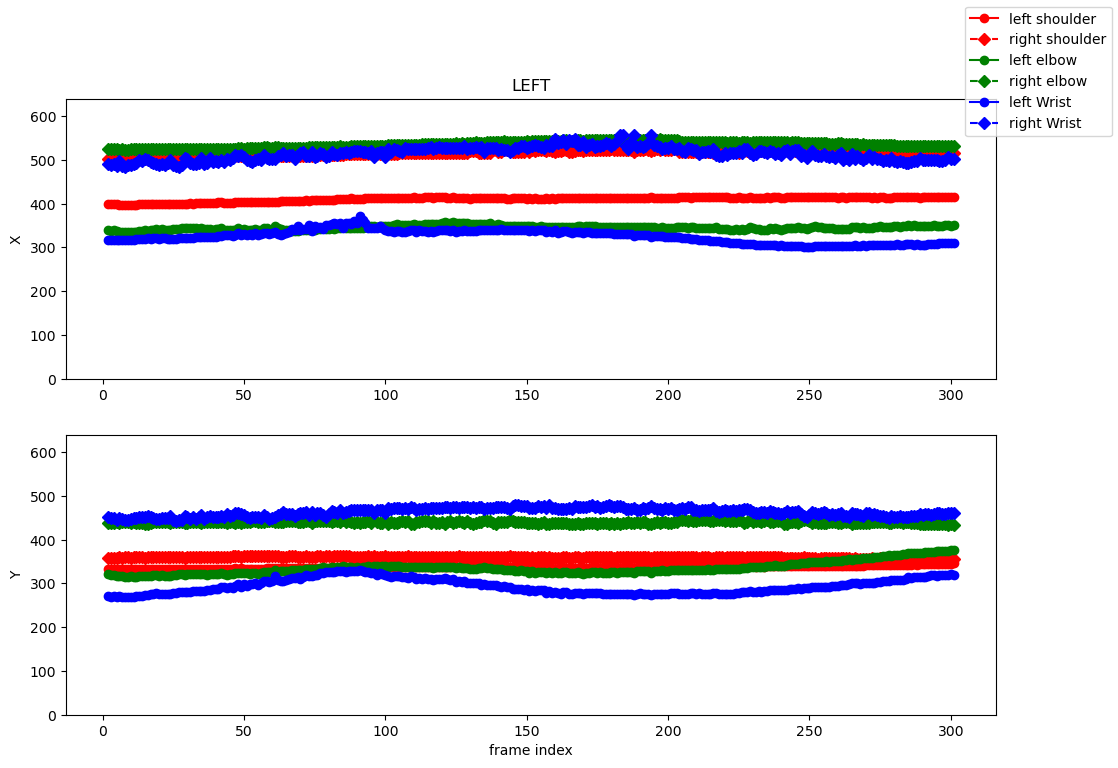

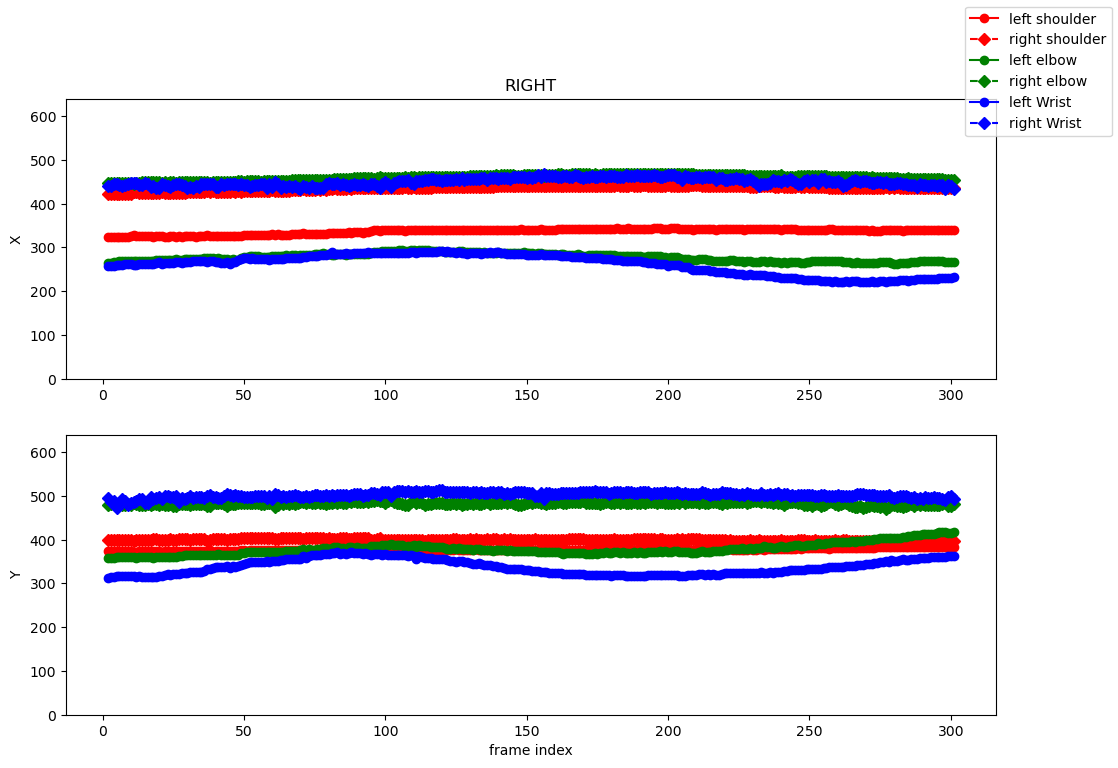

In [8]:
markers=['o','s','D','+','x','^','v','>','<','p','H','8']

def plot_data(dataGT,title):
    leftShoulder = dataGT[:,:3]
    rightShoulder = dataGT[:,3:6]
    leftElbow = dataGT[:,6:9]
    rightElbow = dataGT[:,9:12]
    leftWrist = dataGT[:,12:15]
    rightWrist = dataGT[:,15:18]
    fig,ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].plot(leftShoulder[:,0],leftShoulder[:,1],color="r",linestyle="-",marker='o',label="left shoulder")
    ax[1].plot(leftShoulder[:,0],leftShoulder[:,2],color="r",linestyle="-",marker='o')
    ax[0].plot(rightShoulder[:,0],rightShoulder[:,1],color="r",linestyle="--",marker='D',label="right shoulder")
    ax[1].plot(rightShoulder[:,0],rightShoulder[:,2],color="r",linestyle="--",marker='D')
    ax[0].plot(leftElbow[:,0],leftElbow[:,1],color="g",linestyle="-",marker='o',label="left elbow")
    ax[1].plot(leftElbow[:,0],leftElbow[:,2],color="g",linestyle="-",marker='o')
    ax[0].plot(rightElbow[:,0],rightElbow[:,1],color="g",linestyle="--",marker='D',label="right elbow")
    ax[1].plot(rightElbow[:,0],rightElbow[:,2],color="g",linestyle="--",marker='D')
    ax[0].plot(leftWrist[:,0],leftWrist[:,1],color="b",linestyle="-",marker='o',label="left Wrist")
    ax[1].plot(leftWrist[:,0],leftWrist[:,2],color="b",linestyle="-",marker='o')
    ax[0].plot(rightWrist[:,0],rightWrist[:,1],color="b",linestyle="--",marker='D',label="right Wrist")
    ax[1].plot(rightWrist[:,0],rightWrist[:,2],color="b",linestyle="--",marker='D')
    ax[0].set_ylim(0,640)
    ax[1].set_ylim(0,640)
    ax[0].set_ylabel("X")
    ax[1].set_ylabel("Y")
    ax[1].set_xlabel("frame index")
    ax[0].set_title(title)
    fig.legend()
    plt.show()

plot_data(dataGT_left,title="LEFT")
plot_data(dataGT_right,title="RIGHT")

# Make movie

## Define function 

### Constant value

In [14]:
#ROI size
ROISIZE=35
COLOR_GT = [255,255,255]
COLOR_RT = [255,0,0]
IMGSIZE = (640,640)

In [16]:
class Video():
    def __init__(self,dataGT,videoFps,videoPath,saveImgDir,outputVideoName,imgsz=IMGSIZE,sizeRoi=ROISIZE,colorGT=COLOR_GT,colorRT=COLOR_RT):
        self.sizeRoi =sizeRoi
        self.dataGT = dataGT
        self.videoFps = videoFps
        self.videoPath = videoPath
        self.saveImgDir = saveImgDir
        self.outputVideoName = outputVideoName
        self.imgsz = imgsz
        self.colorGT = colorGT
        self.colorRT=colorRT
        #draw rectangle in images
        self.editVideo()
        #make video from images
        self.makeVideo()

    def drawRectangle(self,frame,centerX,centerY,color,sizeRoi=ROISIZE,width=320,height=320):
        cv2.rectangle(frame,(min(max(int(centerX-ROISIZE/2),0),width),min(max(int(centerY-ROISIZE/2),0),height)),(max(min(int(centerX+ROISIZE/2),width),0),max(min(int(centerY+ROISIZE/2),height),0)),thickness=2,color=color)

    def editVideo(self):
        #arrange data
        leftShoulderGT = self.dataGT[:,:3]
        rightShoulderGT = self.dataGT[:,3:6]
        leftElbowGT = self.dataGT[:,6:9]
        rightElbowGT = self.dataGT[:,9:12]
        leftWristGT = self.dataGT[:,12:15]
        rightWristGT = self.dataGT[:,15:18]

        # Open the video file
        cap = cv2.VideoCapture(self.videoPath)

        # Check if the video file opened successfully
        if not cap.isOpened():
            print("Error opening video file")
            return

        # Create the output folder if it doesn't exist
        if not os.path.exists(self.saveImgDir):
            os.makedirs(self.saveImgDir)

        # Get the frames per second (fps) and frame dimensions
        #fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Start reading and saving frames
        counter = 1
        while True:
            print(counter)
            ret, frame = cap.read()

            if not ret:
                break
            
            #groundTruth
            #LS
            if counter in leftShoulderGT[:,0]: #detected
                [indexLS] = np.where(leftShoulderGT[:,0]==counter)[0]
                centerX = leftShoulderGT[indexLS,1]
                centerY = leftShoulderGT[indexLS,2]
                self.drawRectangle(frame,centerX=centerX,centerY=centerY,color=self.colorGT,width=width,height=height)
            #RS
            if counter in rightShoulderGT[:,0]:
                [indexRS] = np.where(rightShoulderGT[:,0]==counter)[0]
                [centerX,centerY] = rightShoulderGT[indexRS,1:]
                self.drawRectangle(frame,centerX=centerX,centerY=centerY,color=self.colorGT,width=width,height=height)
            #LE
            if counter in leftElbowGT[:,0]:
                [indexLE] = np.where(leftElbowGT[:,0]==counter)[0]
                [centerX,centerY] = leftElbowGT[indexLE,1:]
                self.drawRectangle(frame,centerX=centerX,centerY=centerY,color=self.colorGT,width=width,height=height)
            #RE
            if counter in rightElbowGT[:,0]:
                [indexRE] = np.where(rightElbowGT[:,0]==counter)[0]
                [centerX,centerY] = rightElbowGT[indexRE,1:]
                self.drawRectangle(frame,centerX=centerX,centerY=centerY,color=self.colorGT,width=width,height=height)
            #LW
            if counter in leftWristGT[:,0]:
                [indexLW] = np.where(leftWristGT[:,0]==counter)[0]
                [centerX,centerY] = leftWristGT[indexLW,1:]
                self.drawRectangle(frame,centerX=centerX,centerY=centerY,color=self.colorGT,width=width,height=height)
            #RW
            if counter in rightWristGT[:,0]:
                [indexRW] = np.where(rightWristGT[:,0]==counter)[0]
                [centerX,centerY] = rightWristGT[indexRW,1:]
                self.drawRectangle(frame,centerX=centerX,centerY=centerY,color=self.colorGT,width=width,height=height)
                
            # Save the frame as an image
            frame_filename = os.path.join(self.saveImgDir, f"{counter:03d}.png")
            cv2.imwrite(frame_filename, frame)

            counter += 1
        # Release the video capture object
        cap.release()

    def atoi(self,text):
        return int(text) if text.isdigit() else text

    def natural_keys(self,text):
        return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]

    def makeVideo(self):
        img_array=[]
        for filename in sorted(glob.glob(f"{self.saveImgDir}/*.png"), key=self.natural_keys):
            img = cv2.imread(filename)
            height, width, layers = img.shape
            size = (width, height)
            img_array.append(img)

        out = cv2.VideoWriter(self.outputVideoName, cv2.VideoWriter_fourcc(*'mp4v'), self.videoFps, self.imgsz)

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()

In [18]:
#ROI size
ROISIZE=35
COLOR_GT = [255,255,255]
COLOR_RT = [255,0,0]
IMGSIZE = (640,640)
CAMERA = "left"
dataGT = dataGT_left
rootDir = r"C:\Users\kawaw\data_tracking\1212\humanMotion"
VideoPath = os.path.join(rootDir,"humanMotion_short_{}.mp4".format(CAMERA))
SaveImgDir = os.path.join(rootDir,"edit_{}_short".format(CAMERA))
OutputVideoName = os.path.join(rootDir,"humanMotion_short_{}_GT.mp4".format(CAMERA))
video = Video(dataGT=dataGT,videoFps=30,videoPath=VideoPath,saveImgDir=SaveImgDir,outputVideoName=OutputVideoName,imgsz=IMGSIZE,sizeRoi=ROISIZE,colorGT=COLOR_GT,colorRT=COLOR_RT)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
